In [1]:
# Import from Qiskit
from qiskit import BasicAer , Aer , IBMQ
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, TwoLocal, ExcitationPreserving
from qiskit.utils import QuantumInstance
# from qiskit.tools.monitor import job_monitor

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.opflow import Z2Symmetries
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
#from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.algorithms import VQE, NumPyEigensolver, NumPyMinimumEigensolver
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.drivers import UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.settings import settings
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

# Import from other python libraries
import numpy as np
import matplotlib . pyplot as plt
import pylab as py

In [2]:
# IBMQ.save_account(TOKEN)
IBMQ.load_account()

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q-skku')
print("backend name \t num_qubits")
for backend in provider.backends():
    print(backend, backend.configuration().n_qubits)

backend name 	 num_qubits
ibmq_qasm_simulator 32
ibmq_kolkata 27
ibmq_mumbai 27
ibmq_guadalupe 16
simulator_statevector 32
simulator_mps 100
simulator_extended_stabilizer 63
simulator_stabilizer 5000
ibm_hanoi 27
ibm_algiers 27
ibm_lagos 7
ibm_nairobi 7
ibm_cairo 27
ibm_auckland 27
ibm_perth 7
ibm_sherbrooke 127
ibm_brisbane 127
ibm_nazca 127
ibm_cusco 127


In [4]:
dist = 0.74
basis ='sto3g '
driver = PySCFDriver ( atom ="H .0 .0 .0; H .0 .0 " + str( dist ),
                       unit = UnitsType. ANGSTROM , 
                       charge =0, spin =0, basis = basis )
settings.dict_aux_operators = True


problem = ElectronicStructureProblem(driver)
second_q_ops = problem.second_q_ops()
print(problem.grouped_property_transformed.get_property("num_particles"))

None


/usr/local/lib/python3.7/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [5]:
basis ='sto3g '
#basis ='4-31G'
#사용할 환경을 결정한다.
# Simulators
SV = " statevector "
QA = " qasm "
AS = " aer"

#Real Backend
RM = " real"

# Optimizers
CO = " COBYLA "
BF = " L_BFGS_B "
SL = " SLSQP "
SP = " SPSA "

# Quantum Instances for running the quantum circuit
quantum_instances = {
SV: QuantumInstance ( backend = Aer . get_backend ('statevector_simulator')),
QA: QuantumInstance ( backend = Aer. get_backend ('qasm_simulator')),
AS: QuantumInstance ( backend = Aer. get_backend ('aer_simulator')),
RM: QuantumInstance ( backend = provider.get_backend('ibmq_guadalupe'))}

# Classical Optimizers for parameter minimization
#최대 작업수
MAX_ITER = 250
optimizers = {
#CO잘됨
CO: COBYLA ( maxiter = MAX_ITER ),
#BF 잘안됨
BF: L_BFGS_B ( maxiter = MAX_ITER ),
#SL 잘안됨
SL: SLSQP ( maxiter = MAX_ITER ),
#SP 잘됨
SP: SPSA ( maxiter = MAX_ITER) }
# Quantum simulator
quantum_instance = quantum_instances [RM]
# Classical optimizer .
optimizer = optimizers [CO]

intermediate_info = {
'nfev ': [],
'parameters ': [],
'energy ': [],
'stddev ': []
}
#각 iteration에서 정보를 저장하는 함수
def callback (nfev , parameters , energy , stddev ):
    intermediate_info ['nfev ']. append ( nfev )
    intermediate_info ['parameters ']. append ( parameters )
    intermediate_info ['energy ']. append ( energy )
    intermediate_info ['stddev ']. append ( stddev )
    
d_arr =[]
e_arr =[]
t0_arr = []
t1_arr = []
t2_arr = []
exact_arr = []
repulsive_arr = []
qoulomb_arr = []

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
/root/.local/lib/python3.7/site

### Queue가 너무 오래걸려서... dist별로 에너지의 최솟값을 뽑는건 할 수 없었음
### 대신, dist=0.74로 고정하고, 이 때의 에너지의 최솟값을 뽑는걸로 하되, VQE로 Ground state를 구했을 때 initial Energy와 얼마나 차이나는지를 비교해보자.

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:65: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.


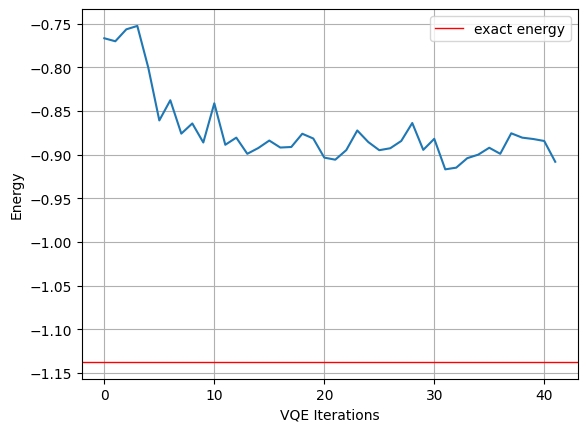

In [6]:
dist = 0.74
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
freeze_core=True


driver = PySCFDriver ( atom ="H .0 .0 .0; H .0 .0 " + str( dist ), unit = UnitsType. ANGSTROM , charge =0, spin =0, basis = basis )
settings.dict_aux_operators = True

problem = ElectronicStructureProblem(driver)
second_q_ops = problem.second_q_ops()
FermionicOp.set_truncation(0)
main_op = second_q_ops['ElectronicEnergy']

particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_particles = (particle_number.num_alpha, particle_number.num_beta)
num_orbitals = particle_number.num_spin_orbitals
qubitOp = converter.convert(main_op, num_particles=num_particles,)

init_state = HartreeFock(num_orbitals, num_particles, converter)
ansatz = UCCSD(qubit_converter=converter, num_particles=num_particles, num_spin_orbitals=num_orbitals, initial_state=init_state)
vqe = VQE(ansatz , optimizer , callback = callback, quantum_instance = quantum_instance )

result = vqe.compute_minimum_eigenvalue(qubitOp)
electronic_structure_result = problem.interpret(result)
#핵 간의 밀어내는 에너지를 얻어낸다. (이는 전자의 구조에 의해 변하지 않는 일정한 값이다.)
shift = electronic_structure_result.nuclear_repulsion_energy
#최종 에너지 계산값
vqe_result = result.eigenvalue.real #+shift
qoulomb = vqe_result
repulsion = shift
energy = qoulomb + repulsion
exact_energy = exact_solver(qubitOp, problem).total_energies[0].real
qoulomb_arr.append(qoulomb)
repulsive_arr.append(repulsion)
d_arr.append(dist)
exact_arr.append(exact_energy)


plt.plot(intermediate_info['energy '])
plt.axhline(y = exact_arr[-1], color = 'r', linewidth = 1, label = 'exact energy')
plt.xlabel('VQE Iterations')
plt.ylabel('Energy')
plt.grid()
plt.legend()
plt.show()


#plt.plot(d_arr,qoulomb_arr,label ='vqe_result')
#plt.plot(d_arr,repulsive_arr, label = 'repulsion')
# plt.scatter(d_arr,e_arr,marker='x', label = 'VQE Energy')
# plt.plot(d_arr,exact_arr,label = 'exact energy',color='red')
# plt.grid()
# plt.legend()
# plt.xlabel("dist(angstrom)")
# plt.ylabel('energy')
# plt.show()

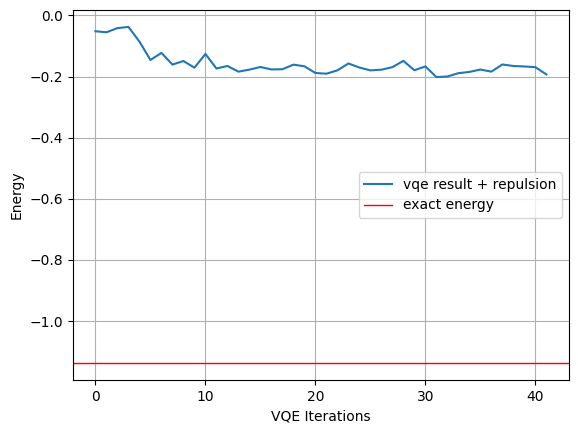

0.7151043390810812 -1.1372838344885012 -0.19310199096338931


In [13]:
plt.plot(intermediate_info['energy '] + repulsion, label = 'vqe result + repulsion')
plt.axhline(y = exact_arr[-1], color = 'r', linewidth = 1, label = 'exact energy')
plt.xlabel('VQE Iterations')
plt.ylabel('Energy')
plt.grid()
plt.legend()
plt.show()
print(repulsion, exact_arr[-1], intermediate_info['energy '][-1] + repulsion)

In [ ]:
plt.plot(d_arr,qoulomb_arr,label ='attractive energy + nuclei energy')
plt.plot(d_arr,repulsive_arr, label = 'repulsion')
plt.plot(d_arr,e_arr, label = 'VQE Energy')

plt.grid()
plt.legend()
plt.xlabel("dist(angstrom)")
plt.ylabel('energy')
plt.show()

In [ ]:
print(len(intermediate_info['parameters '][0]))

In [ ]:
12000/92